# **News Headline Classification using LSTMs and GRUs**

## **Dataset**
- [News Headlines Dataset](https://www.kaggle.com/rmisra/news-category-dataset): news headlines labeled with sentiment, covering various news topics and categories.

<font color='green'>### YOUR ANSWER HERE ###</font>

The idea of categorizing news headlines and descriptions grabbed my attention because in one of my other classes we learned about web scrapers, and the various techniques behind it. And, I assume these headlines, descriptions, etc. have been collected using some type of web scraper.

In [35]:
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
import torch
#import torchtext
#from torchtext.data.utils import get_tokenizer
#from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
#import torchtext.transforms as T
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is not available.


## **Part 1:** Data Exploration & Preprocessing

In [ ]:
# Function to safely load JSON lines
def safe_json_loads(line):
    try:
        return json.loads(line)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None

# path = "C:/Users/hansm/OneDrive/Documents/DL/Assignment2/News_Category_Dataset_v3.json"
path = "/content/News_Category_Dataset_v3.json"
# Reading the JSON file and inputting the data into a single list, where each element is one entry.
with open(path, "r") as f:
    data = [safe_json_loads(line) for line in f if line.strip()]

# Filter out None values (lines that failed to parse)
data = [entry for entry in data if entry is not None]

# Converting the list into a Pandas DataFrame to more easily manipulate it.
entries = pd.DataFrame(data)

# Pandas conveniently splits each JSON entry into columns
entries.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
# For this assignment, we will be predicting the category of the news headline based upon its headline and
# short description. Therefore, we will remove the unecessary columns.
entries = entries.drop(columns = ["link", "authors", "date"])

In [ ]:
# viewing the summary statistics of our data
entries.describe()

,headline,category,short_description
count,209527,209527,209527
unique,207996,42,187022
top,Sunday Roundup,POLITICS,
freq,90,35602,19712


In [ ]:
# Checking for null values
entries.isnull().sum()

headline             0
category             0
short_description    0
dtype: int64

In [ ]:
num_categories = entries['category'].nunique()
print(f"Number of unique categories: {num_categories}")

# Here, we see the number of entries we have for each category
entries['category'].value_counts()

Number of unique categories: 42


category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

In [ ]:
categories_idx = entries['category'].value_counts().index

def groupper(grouplist, name):
    mapping = {cat: name for cat in grouplist}
    entries['category'] = entries['category'].replace(mapping)

# GROUPINGS FROM: https://www.kaggle.com/code/derinrobert/newsclassification-using-lstm-val-acc-72
groupper(grouplist=['WELLNESS', 'HEALTHY LIVING', 'HOME & LIVING', 'STYLE & BEAUTY', 'STYLE'], name = 'LIFESTYLE AND WELLNESS')
groupper(grouplist=['PARENTING', 'PARENTS', 'EDUCATION', 'COLLEGE'], name = 'PARENTING AND EDUCATION')
groupper(grouplist=['SPORTS', 'ENTERTAINMENT', 'COMEDY', 'WEIRD NEWS', 'ARTS'], name = 'SPORTS AND ENTERTAINMENT')
groupper(grouplist=['TRAVEL', 'ARTS & CULTURE', 'CULTURE & ARTS', 'FOOD & DRINK', 'TASTE'], name = 'TRAVEL-TOURISM & ART-CULTURE')
groupper(grouplist=['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'], name = 'EMPOWERED VOICES')
groupper(grouplist=['BUSINESS',  'MONEY'], name = 'BUSINESS-MONEY')
groupper(grouplist=['THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS'], name = 'WORLDNEWS')
groupper(grouplist=['ENVIRONMENT', 'GREEN'], name = 'ENVIRONMENT')
groupper(grouplist=['TECH', 'SCIENCE'], name = 'SCIENCE AND TECH')
groupper(grouplist=['FIFTY', 'IMPACT', 'GOOD NEWS', 'CRIME', 'U.S. NEWS'], name = 'GENERAL')
groupper(grouplist=['WEDDINGS', 'DIVORCE',  'RELIGION', 'MEDIA'], name = 'MISC')

num_categories = entries['category'].nunique()
print(num_categories)
entries['category'].value_counts()

12


category
LIFESTYLE AND WELLNESS          41027
POLITICS                        35602
SPORTS AND ENTERTAINMENT        32125
TRAVEL-TOURISM & ART-CULTURE    20749
EMPOWERED VOICES                15632
PARENTING AND EDUCATION         14904
MISC                            12600
GENERAL                         11222
WORLDNEWS                        9542
BUSINESS-MONEY                   7748
SCIENCE AND TECH                 4310
ENVIRONMENT                      4066
Name: count, dtype: int64

In [ ]:
categories, category_labels = pd.factorize(entries['category'])
print(category_labels)
print(categories)

Index(['GENERAL', 'SPORTS AND ENTERTAINMENT', 'PARENTING AND EDUCATION',
       'WORLDNEWS', 'TRAVEL-TOURISM & ART-CULTURE', 'SCIENCE AND TECH',
       'POLITICS', 'ENVIRONMENT', 'LIFESTYLE AND WELLNESS', 'BUSINESS-MONEY',
       'MISC', 'EMPOWERED VOICES'],
      dtype='object')
[0 0 1 ... 1 1 1]


In [ ]:
# Viewing the first 5 short descriptions
for i in range(5):
    print(entries['short_description'][i])
    print()

Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.

He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.

"Until you have a dog you don't understand what could be eaten."

"Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."

Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.



- 1.1 The data consists of news headlines from HuffPost from 2012 to 2022. In addition to the headline, a short description, the author(s), date of publication, news category, and web link are provided.

- 1.2 The data is in the form of a JSON file, with each line representing a different headline. This data has then been pre-processed into a pandas dataframe.

- 1.3 There are 209,526 entries and 6 variables. However, we will only be using the articles' headline and short description to predict its category. Therefore, after pre-processing we are left with just these 3 variables.


## **STEP 2:** Data Visualization

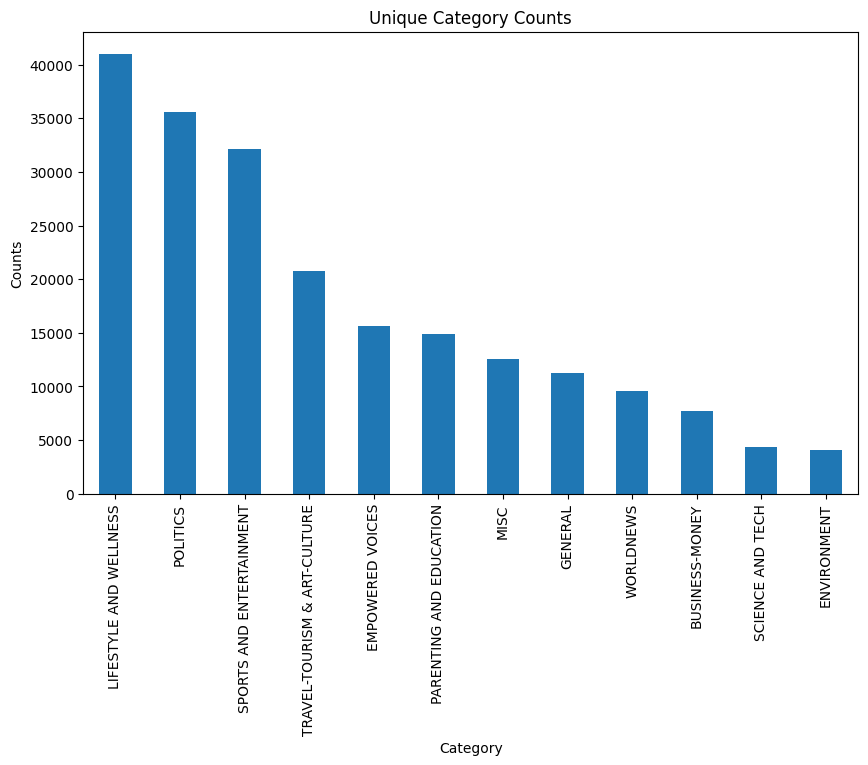

In [ ]:
category_counts = entries['category'].value_counts()
category_counts.plot(kind = "bar", figsize = (10,6))
plt.title('Unique Category Counts')
plt.ylabel("Counts")
plt.xlabel("Category")
plt.show()

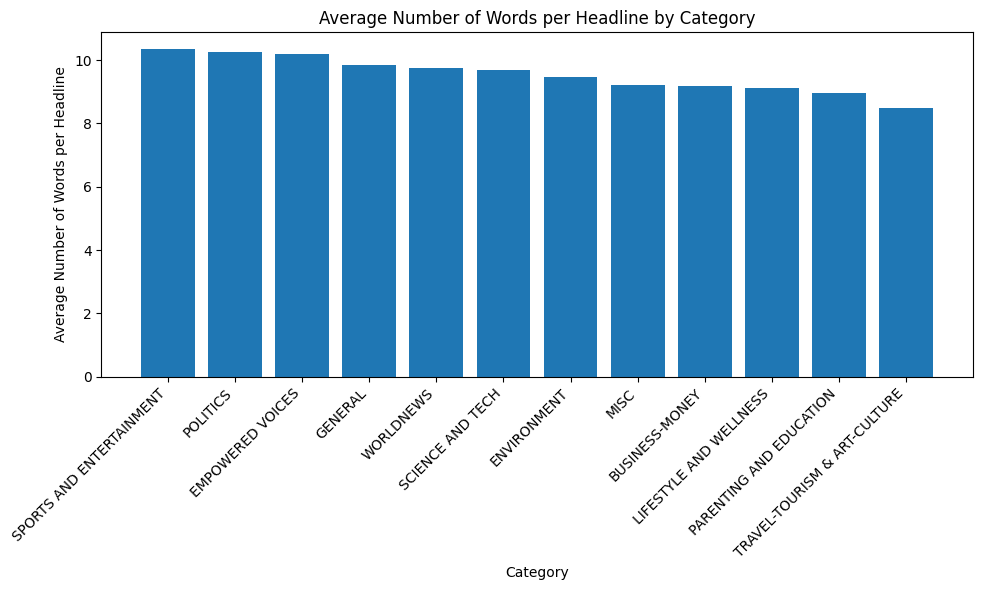

In [ ]:
headline_average_words = []

for i in category_labels:
    headline_idx = entries[entries["category"] == i]
    headline_average_words.append(np.mean(headline_idx['headline'].apply(lambda x : len(x.split()))))

headline_idx = pd.DataFrame({
    "Category" : category_labels,
    "Average": headline_average_words
})

headline_idx = headline_idx.sort_values(['Average'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(headline_idx['Category'], headline_idx['Average'])
plt.xlabel('Category')
plt.ylabel('Average Number of Words per Headline')
plt.title('Average Number of Words per Headline by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

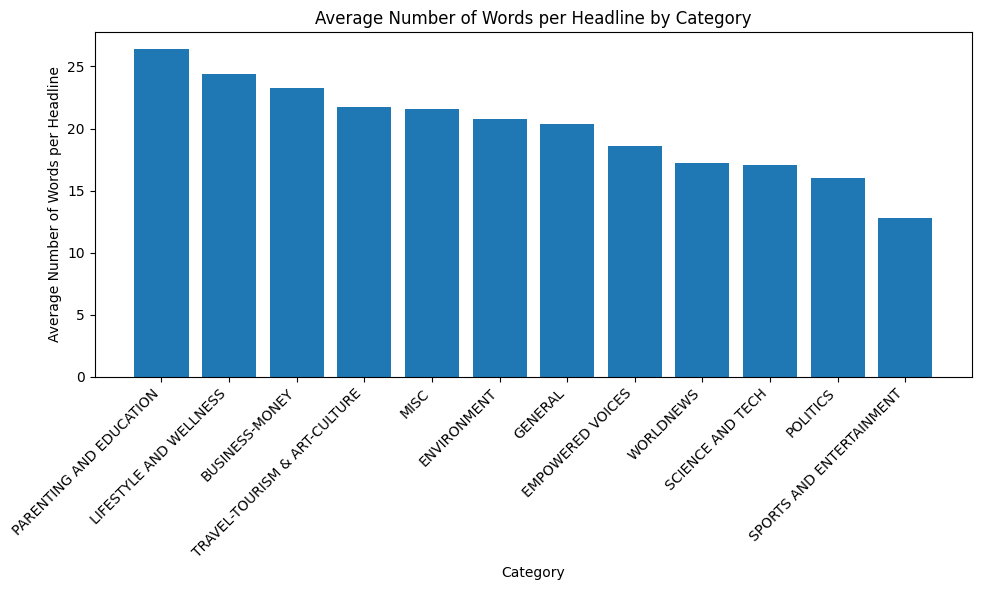

In [ ]:
description_average_words = []

for i in category_labels:
    description_idx = entries[entries["category"] == i]
    description_average_words.append(np.mean(description_idx['short_description'].apply(lambda x : len(x.split()))))

description_idx = pd.DataFrame({
    "Category" : category_labels,
    "Average": description_average_words
})

description_idx = description_idx.sort_values(['Average'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(description_idx['Category'], description_idx['Average'])
plt.xlabel('Category')
plt.ylabel('Average Number of Words per Headline')
plt.title('Average Number of Words per Headline by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **STEP 3:** Prepare the Datasets

- Tokenizing the text and converting it into numerical sequences.

- Splitting it into training, validation and test sets.

In [ ]:
# Combining the headline and short_description variables (preparing for tokenization)
texts = entries['headline'] + ' ' + entries['short_description']
for i in range(5):
    print(texts[i])
    print()

Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.

American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.

23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don't understand what could be eaten."

The Funniest Tweets From Parents This Week (Sept. 17-23) "Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."

Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and bra

In [ ]:
# Defining the tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Tokenizing the text into a list of lists
tokenized_text = [tokenizer(text) for text in texts]

In [ ]:
# Building the vocabulary
def yield_tokens():
    for tokens in tokenized_text:
        yield tokens

token_generator = yield_tokens()
vocab = build_vocab_from_iterator(token_generator, specials = ['<pad>', '<sos>', '<eos>', '<unk>'], special_first=True)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
print(len(vocab))

125992


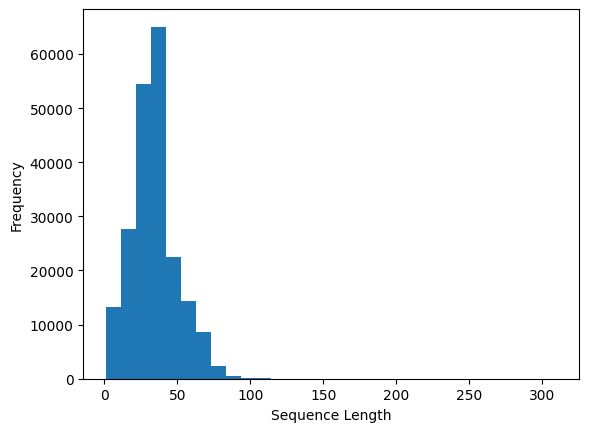

In [ ]:
lengths = [len(tokens) for tokens in tokenized_text]
plt.hist(lengths, bins = 30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Setting maximum sequence length
max_length = 60

# Transforming tokens
transformed_tokens = T.Sequential(
    # a list of lists, where each list contains the the tokens (numerical values) for each word in the original entry
    T.VocabTransform(vocab = vocab),
    # adds <sos> to the beginning of each sentence: 1 is the index of <sos> in the vocab
    T.AddToken(1, begin = True),
    # each entry is truncated to the max_length variable, because each list must have the same number of values to be inputted into the LSTM model
    T.Truncate(max_seq_len = max_length),
    # adds <eos> to the end of each sentence: 2 is the index of <eos> in the vocab
    T.AddToken(2, begin = False),
    # adds the <pad> token if the list is shorter than max_length and converts the list to a tensor
    T.ToTensor(padding_value = 0)
)

In [ ]:
# splitting the tokens (in the form of a list of lists) into training, validation, and testing sets, along with their labels
train_tokens, temp_tokens, train_categories, temp_categories = train_test_split(tokenized_text, categories, test_size=0.3)
val_tokens, test_tokens, val_categories, test_categories = train_test_split(temp_tokens, temp_categories, test_size = 0.5)

In [ ]:
# Processing the tokens into numerical values using our vocab
train = transformed_tokens(train_tokens).to(device)
train_labels = torch.tensor(train_categories).to(device)
val = transformed_tokens(val_tokens).to(device)
val_labels = torch.tensor(val_categories).to(device)
test = transformed_tokens(test_tokens).to(device)
test_labels = torch.tensor(test_categories).to(device)


In [ ]:
batch_size = 250

# Loading data into DataLoaders
train_dataloader = DataLoader(TensorDataset(train, train_labels), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TensorDataset(val, val_labels), batch_size=batch_size)
test_dataloader = DataLoader(TensorDataset(test, test_labels), batch_size=batch_size)

In [ ]:
no_train_batches = len(train_dataloader)
no_val_batches = len(val_dataloader)
no_test_batches = len(test_dataloader)
print(f"Length of train dataloader: {no_train_batches} batches of {batch_size}")
print(f"Length of val dataloader: {no_val_batches} batches of {batch_size}")
print(f"Length of test dataloader: {no_test_batches} batches of {batch_size}")

Length of train dataloader: 587 batches of 250
Length of val dataloader: 126 batches of 250
Length of test dataloader: 126 batches of 250


## **STEP 4:** LSTM model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, num_layers, dropout, bidirectional=False):
        super().__init__()

        # embedding_size = len(vocab): the number of unique words

        self.embedding = nn.Embedding(embedding_size, hidden_size)

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)

        output, (hidden_out, memory_out) = self.lstm(x)

        output = self.fc(output[:, -1, :])
        return output


#### EXPERIMENT #1

In [ ]:
# Defining hyperparameters
hidden_size = 128
num_layers = 3
dropout = 0.5
learning_rate = 0.001
epochs = 50

# Initializing the model and transferring it to the device (GPU/CPU)
model_1 = LSTM(embedding_size=len(vocab), hidden_size=hidden_size, output_size=num_categories, num_layers=num_layers, dropout=dropout).to(device)

# Defining the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

Training Epoch 1/50: 100%|██████████| 587/587 [00:18<00:00, 32.27it/s]


Epoch #1 | Training Loss: 2.097 | Training Accuracy: 29.61%
Epoch #1 | Validation Loss: 1.929 | Validation Accuracy: 36.95%



Training Epoch 2/50: 100%|██████████| 587/587 [00:15<00:00, 38.24it/s]


Epoch #2 | Training Loss: 1.863 | Training Accuracy: 39.15%
Epoch #2 | Validation Loss: 1.783 | Validation Accuracy: 42.16%



Training Epoch 3/50: 100%|██████████| 587/587 [00:15<00:00, 37.47it/s]


Epoch #3 | Training Loss: 1.734 | Training Accuracy: 43.05%
Epoch #3 | Validation Loss: 1.681 | Validation Accuracy: 45.62%



Training Epoch 4/50: 100%|██████████| 587/587 [00:16<00:00, 36.58it/s]


Epoch #4 | Training Loss: 1.607 | Training Accuracy: 47.32%
Epoch #4 | Validation Loss: 1.558 | Validation Accuracy: 51.10%



Training Epoch 5/50: 100%|██████████| 587/587 [00:16<00:00, 36.31it/s]


Epoch #5 | Training Loss: 1.462 | Training Accuracy: 53.12%
Epoch #5 | Validation Loss: 1.350 | Validation Accuracy: 58.52%



Training Epoch 6/50: 100%|██████████| 587/587 [00:16<00:00, 36.46it/s]


Epoch #6 | Training Loss: 1.342 | Training Accuracy: 57.76%
Epoch #6 | Validation Loss: 1.290 | Validation Accuracy: 61.18%



Training Epoch 7/50: 100%|██████████| 587/587 [00:16<00:00, 35.34it/s]


Epoch #7 | Training Loss: 1.259 | Training Accuracy: 60.65%
Epoch #7 | Validation Loss: 1.245 | Validation Accuracy: 62.98%



Training Epoch 8/50: 100%|██████████| 587/587 [00:16<00:00, 36.08it/s]


Epoch #8 | Training Loss: 1.192 | Training Accuracy: 62.81%
Epoch #8 | Validation Loss: 1.190 | Validation Accuracy: 64.78%



Training Epoch 9/50: 100%|██████████| 587/587 [00:16<00:00, 36.25it/s]


Epoch #9 | Training Loss: 1.135 | Training Accuracy: 64.58%
Epoch #9 | Validation Loss: 1.155 | Validation Accuracy: 65.73%



Training Epoch 10/50: 100%|██████████| 587/587 [00:16<00:00, 36.08it/s]


Epoch #10 | Training Loss: 1.084 | Training Accuracy: 66.15%
Epoch #10 | Validation Loss: 1.141 | Validation Accuracy: 66.49%



Training Epoch 11/50: 100%|██████████| 587/587 [00:16<00:00, 35.67it/s]


Epoch #11 | Training Loss: 1.042 | Training Accuracy: 67.43%
Epoch #11 | Validation Loss: 1.104 | Validation Accuracy: 67.49%



Training Epoch 12/50: 100%|██████████| 587/587 [00:16<00:00, 36.36it/s]


Epoch #12 | Training Loss: 1.005 | Training Accuracy: 68.44%
Epoch #12 | Validation Loss: 1.060 | Validation Accuracy: 68.19%



Training Epoch 13/50: 100%|██████████| 587/587 [00:16<00:00, 36.25it/s]


Epoch #13 | Training Loss: 0.971 | Training Accuracy: 69.54%
Epoch #13 | Validation Loss: 1.065 | Validation Accuracy: 68.48%



Training Epoch 14/50: 100%|██████████| 587/587 [00:16<00:00, 36.48it/s]


Epoch #14 | Training Loss: 0.934 | Training Accuracy: 70.58%
Epoch #14 | Validation Loss: 1.044 | Validation Accuracy: 68.98%



Training Epoch 15/50: 100%|██████████| 587/587 [00:16<00:00, 35.40it/s]


Epoch #15 | Training Loss: 0.909 | Training Accuracy: 71.38%
Epoch #15 | Validation Loss: 1.029 | Validation Accuracy: 69.40%



Training Epoch 16/50: 100%|██████████| 587/587 [00:16<00:00, 35.67it/s]


Epoch #16 | Training Loss: 0.879 | Training Accuracy: 72.21%
Epoch #16 | Validation Loss: 1.032 | Validation Accuracy: 69.60%



Training Epoch 17/50: 100%|██████████| 587/587 [00:16<00:00, 36.47it/s]


Epoch #17 | Training Loss: 0.855 | Training Accuracy: 73.03%
Epoch #17 | Validation Loss: 1.038 | Validation Accuracy: 69.76%



Training Epoch 18/50: 100%|██████████| 587/587 [00:16<00:00, 36.47it/s]


Epoch #18 | Training Loss: 0.832 | Training Accuracy: 73.64%
Epoch #18 | Validation Loss: 1.013 | Validation Accuracy: 70.45%



Training Epoch 19/50: 100%|██████████| 587/587 [00:16<00:00, 35.07it/s]


Epoch #19 | Training Loss: 0.811 | Training Accuracy: 74.22%
Epoch #19 | Validation Loss: 1.012 | Validation Accuracy: 70.41%



Training Epoch 20/50: 100%|██████████| 587/587 [00:16<00:00, 36.28it/s]


Epoch #20 | Training Loss: 0.788 | Training Accuracy: 74.96%
Epoch #20 | Validation Loss: 1.030 | Validation Accuracy: 70.33%



Training Epoch 21/50: 100%|██████████| 587/587 [00:16<00:00, 36.30it/s]


Epoch #21 | Training Loss: 0.769 | Training Accuracy: 75.48%
Epoch #21 | Validation Loss: 1.021 | Validation Accuracy: 70.69%



Training Epoch 22/50: 100%|██████████| 587/587 [00:16<00:00, 34.91it/s]


Epoch #22 | Training Loss: 0.747 | Training Accuracy: 76.17%
Epoch #22 | Validation Loss: 1.023 | Validation Accuracy: 70.61%

Early stopping condition met. Validation loss is increasing.


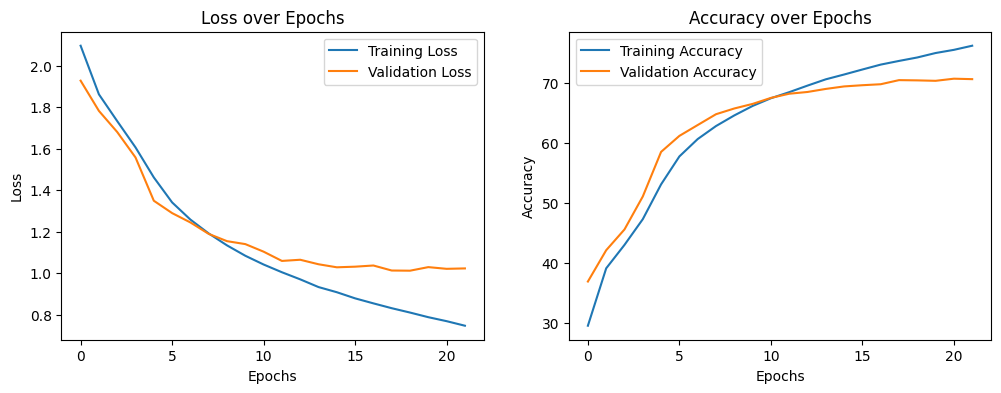

In [ ]:
# Training the model
train_acc = []
val_acc = []
train_loss = []
val_loss = []
previous_val_loss = float('inf')
val_patience = 3
val_counter = 0

for epoch in range(epochs):
    model_1.train()
    train_true = []
    train_pred = []
    train_running_loss = 0.0

    for inputs, targets in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        train_inputs, train_targets = inputs.to(device), targets.to(device)

        # zeroing the parameter gradients
        optimizer.zero_grad()

        # forward pass through the LSTM model
        train_outputs = model_1(train_inputs)

        # calculating the loss for each batch
        loss = loss_function(train_outputs, train_targets)
        train_running_loss += loss.item()

        # backpropogation
        loss.backward()
        optimizer.step()

        # appending predictions and true outputs
        _, pred = torch.max(train_outputs, 1)
        train_true.extend(train_targets.cpu().numpy())
        train_pred.extend(pred.cpu().numpy())

    model_1.eval()
    val_true = []
    val_pred = []
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            val_inputs, val_targets = inputs.to(device), targets.to(device)

            # forward pass
            val_outputs = model_1(val_inputs)

            # calculating the loss
            loss = loss_function(val_outputs, val_targets)
            val_running_loss += loss.item()

            # appending predictions and true answers
            _, pred = torch.max(val_outputs, 1)
            val_true.extend(val_targets.cpu().numpy())
            val_pred.extend(pred.cpu().numpy())

    train_loss.append(train_running_loss / len(train_dataloader))
    train_acc.append((np.array(train_true) == np.array(train_pred)).sum() / len(train_true) * 100)
    val_loss.append(val_running_loss / len(val_dataloader))
    val_acc.append((np.array(val_true) == np.array(val_pred)).sum() / len(val_true) * 100)

    print(f"Epoch #{epoch+1} | Training Loss: {train_loss[-1]:.3f} | Training Accuracy: {train_acc[-1]:.2f}%")
    print(f"Epoch #{epoch+1} | Validation Loss: {val_loss[-1]:.3f} | Validation Accuracy: {val_acc[-1]:.2f}%\n")

    # Early stopping
    if val_loss[-1] > previous_val_loss:
        val_counter += 1
        if val_counter >= val_patience:
            print('Early stopping condition met. Validation loss is increasing.')
            break
    else:
        previous_val_loss = val_loss[-1]
        val_counter = 0

# Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

#### EXPERIMENT #2

In [ ]:
# initializing model parameters
hidden_size = 256
num_layers = 6
dropout = 0.2
learning_rate = 0.001
epochs = 50

# Initializing the model and transferring it to the device (GPU/CPU)
model_2 = LSTM(embedding_size=len(vocab), hidden_size=hidden_size, output_size=num_categories, num_layers=num_layers, dropout=dropout).to(device)

# Defining the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

Training Epoch 1/50: 100%|██████████| 587/587 [01:07<00:00,  8.64it/s]


Epoch #1 | Training Loss: 2.009 | Training Accuracy: 33.64%
Epoch #1 | Validation Loss: 1.853 | Validation Accuracy: 40.18%



Training Epoch 2/50: 100%|██████████| 587/587 [01:08<00:00,  8.61it/s]


Epoch #2 | Training Loss: 1.756 | Training Accuracy: 42.55%
Epoch #2 | Validation Loss: 1.667 | Validation Accuracy: 45.33%



Training Epoch 3/50: 100%|██████████| 587/587 [01:08<00:00,  8.60it/s]


Epoch #3 | Training Loss: 1.541 | Training Accuracy: 49.65%
Epoch #3 | Validation Loss: 1.441 | Validation Accuracy: 54.31%



Training Epoch 4/50: 100%|██████████| 587/587 [01:08<00:00,  8.54it/s]


Epoch #4 | Training Loss: 1.301 | Training Accuracy: 59.17%
Epoch #4 | Validation Loss: 1.260 | Validation Accuracy: 61.50%



Training Epoch 5/50: 100%|██████████| 587/587 [01:08<00:00,  8.60it/s]


Epoch #5 | Training Loss: 1.133 | Training Accuracy: 65.11%
Epoch #5 | Validation Loss: 1.165 | Validation Accuracy: 64.66%



Training Epoch 6/50: 100%|██████████| 587/587 [01:08<00:00,  8.60it/s]


Epoch #6 | Training Loss: 1.014 | Training Accuracy: 68.85%
Epoch #6 | Validation Loss: 1.122 | Validation Accuracy: 66.31%



Training Epoch 7/50: 100%|██████████| 587/587 [01:08<00:00,  8.62it/s]


Epoch #7 | Training Loss: 0.914 | Training Accuracy: 71.76%
Epoch #7 | Validation Loss: 1.085 | Validation Accuracy: 67.49%



Training Epoch 8/50: 100%|██████████| 587/587 [01:08<00:00,  8.62it/s]


Epoch #8 | Training Loss: 0.833 | Training Accuracy: 74.20%
Epoch #8 | Validation Loss: 1.074 | Validation Accuracy: 68.08%



Training Epoch 9/50: 100%|██████████| 587/587 [01:08<00:00,  8.60it/s]


Epoch #9 | Training Loss: 0.760 | Training Accuracy: 76.16%
Epoch #9 | Validation Loss: 1.066 | Validation Accuracy: 68.86%



Training Epoch 10/50: 100%|██████████| 587/587 [01:08<00:00,  8.57it/s]


Epoch #10 | Training Loss: 0.695 | Training Accuracy: 78.36%
Epoch #10 | Validation Loss: 1.077 | Validation Accuracy: 68.69%



Training Epoch 11/50: 100%|██████████| 587/587 [01:08<00:00,  8.54it/s]


Epoch #11 | Training Loss: 0.639 | Training Accuracy: 80.00%
Epoch #11 | Validation Loss: 1.105 | Validation Accuracy: 68.92%



Training Epoch 12/50: 100%|██████████| 587/587 [01:08<00:00,  8.57it/s]


Epoch #12 | Training Loss: 0.588 | Training Accuracy: 81.54%
Epoch #12 | Validation Loss: 1.103 | Validation Accuracy: 69.13%

Early stopping condition met. Validation loss is increasing.


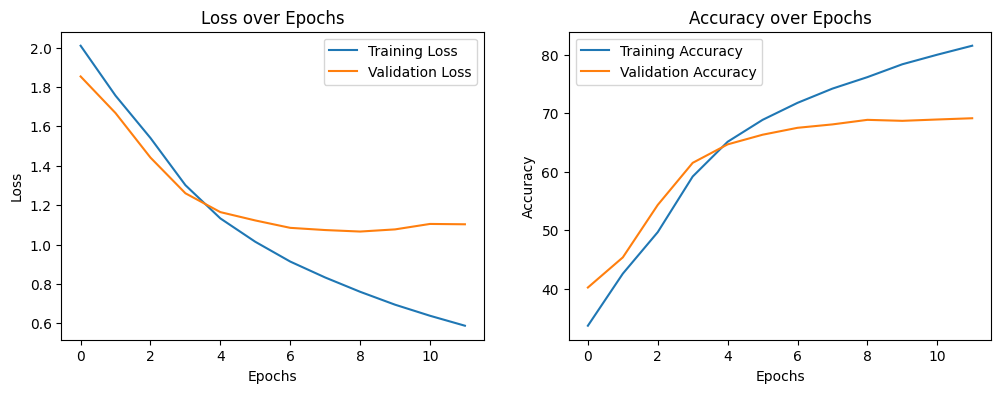

In [ ]:
# Training the model
train_acc = []
val_acc = []
train_loss = []
val_loss = []
previous_val_loss = float('inf')
val_patience = 3
val_counter = 0

for epoch in range(epochs):
    model_2.train()
    train_true = []
    train_pred = []
    train_running_loss = 0.0

    for inputs, targets in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        train_inputs, train_targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        train_outputs = model_2(train_inputs)
        loss = loss_function(train_outputs, train_targets)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, pred = torch.max(train_outputs, 1)
        train_true.extend(train_targets.cpu().numpy())
        train_pred.extend(pred.cpu().numpy())

    model_2.eval()
    val_true = []
    val_pred = []
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            val_inputs, val_targets = inputs.to(device), targets.to(device)

            val_outputs = model_2(val_inputs)
            loss = loss_function(val_outputs, val_targets)
            val_running_loss += loss.item()
            _, pred = torch.max(val_outputs, 1)
            val_true.extend(val_targets.cpu().numpy())
            val_pred.extend(pred.cpu().numpy())

    train_loss.append(train_running_loss / len(train_dataloader))
    train_acc.append((np.array(train_true) == np.array(train_pred)).sum() / len(train_true) * 100)
    val_loss.append(val_running_loss / len(val_dataloader))
    val_acc.append((np.array(val_true) == np.array(val_pred)).sum() / len(val_true) * 100)

    print(f"Epoch #{epoch+1} | Training Loss: {train_loss[-1]:.3f} | Training Accuracy: {train_acc[-1]:.2f}%")
    print(f"Epoch #{epoch+1} | Validation Loss: {val_loss[-1]:.3f} | Validation Accuracy: {val_acc[-1]:.2f}%\n")

    # Early stopping
    if val_loss[-1] > previous_val_loss:
        val_counter += 1
        if val_counter >= val_patience:
            print('Early stopping condition met. Validation loss is increasing.')
            break
    else:
        previous_val_loss = val_loss[-1]
        val_counter = 0
        best_weights_2 = model_2.state_dict()

# Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

#### EXPERIMENT #3

In [ ]:
# initializing model parameters
hidden_size = 256
num_layers = 3
dropout = 0.5
learning_rate = 0.01
epochs = 50

# Initializing the model and transferring it to the device (GPU/CPU)
model_3 = LSTM(embedding_size=len(vocab), hidden_size=hidden_size, output_size=num_categories, num_layers=num_layers, dropout=dropout).to(device)

# Defining the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

Training Epoch 1/50: 100%|██████████| 587/587 [00:37<00:00, 15.82it/s]


Epoch #1 | Training Loss: 1.920 | Training Accuracy: 37.54%
Epoch #1 | Validation Loss: 1.751 | Validation Accuracy: 43.47%



Training Epoch 2/50: 100%|██████████| 587/587 [00:37<00:00, 15.78it/s]


Epoch #2 | Training Loss: 1.683 | Training Accuracy: 44.89%
Epoch #2 | Validation Loss: 1.669 | Validation Accuracy: 46.78%



Training Epoch 3/50: 100%|██████████| 587/587 [00:37<00:00, 15.58it/s]


Epoch #3 | Training Loss: 1.586 | Training Accuracy: 47.89%
Epoch #3 | Validation Loss: 1.630 | Validation Accuracy: 48.82%



Training Epoch 4/50: 100%|██████████| 587/587 [00:37<00:00, 15.76it/s]


Epoch #4 | Training Loss: 1.535 | Training Accuracy: 49.64%
Epoch #4 | Validation Loss: 1.579 | Validation Accuracy: 50.03%



Training Epoch 5/50: 100%|██████████| 587/587 [00:37<00:00, 15.76it/s]


Epoch #5 | Training Loss: 1.512 | Training Accuracy: 50.64%
Epoch #5 | Validation Loss: 1.541 | Validation Accuracy: 51.46%



Training Epoch 6/50: 100%|██████████| 587/587 [00:37<00:00, 15.71it/s]


Epoch #6 | Training Loss: 1.506 | Training Accuracy: 50.92%
Epoch #6 | Validation Loss: 1.565 | Validation Accuracy: 51.57%



Training Epoch 7/50: 100%|██████████| 587/587 [00:37<00:00, 15.76it/s]


Epoch #7 | Training Loss: 1.507 | Training Accuracy: 51.05%
Epoch #7 | Validation Loss: 1.537 | Validation Accuracy: 51.99%



Training Epoch 8/50: 100%|██████████| 587/587 [00:37<00:00, 15.76it/s]


Epoch #8 | Training Loss: 1.522 | Training Accuracy: 50.56%
Epoch #8 | Validation Loss: 1.552 | Validation Accuracy: 51.25%



Training Epoch 9/50: 100%|██████████| 587/587 [00:37<00:00, 15.82it/s]


Epoch #9 | Training Loss: 1.527 | Training Accuracy: 50.51%
Epoch #9 | Validation Loss: 1.553 | Validation Accuracy: 51.30%



Training Epoch 10/50: 100%|██████████| 587/587 [00:37<00:00, 15.66it/s]


Epoch #10 | Training Loss: 1.541 | Training Accuracy: 49.88%
Epoch #10 | Validation Loss: 1.525 | Validation Accuracy: 52.06%



Training Epoch 11/50: 100%|██████████| 587/587 [00:37<00:00, 15.77it/s]


Epoch #11 | Training Loss: 1.543 | Training Accuracy: 50.02%
Epoch #11 | Validation Loss: 1.532 | Validation Accuracy: 52.03%



Training Epoch 12/50: 100%|██████████| 587/587 [00:37<00:00, 15.81it/s]


Epoch #12 | Training Loss: 1.550 | Training Accuracy: 49.82%
Epoch #12 | Validation Loss: 1.528 | Validation Accuracy: 51.94%



Training Epoch 13/50: 100%|██████████| 587/587 [00:37<00:00, 15.84it/s]


Epoch #13 | Training Loss: 1.557 | Training Accuracy: 49.56%
Epoch #13 | Validation Loss: 1.541 | Validation Accuracy: 51.89%

Early stopping condition met. Validation loss is increasing.


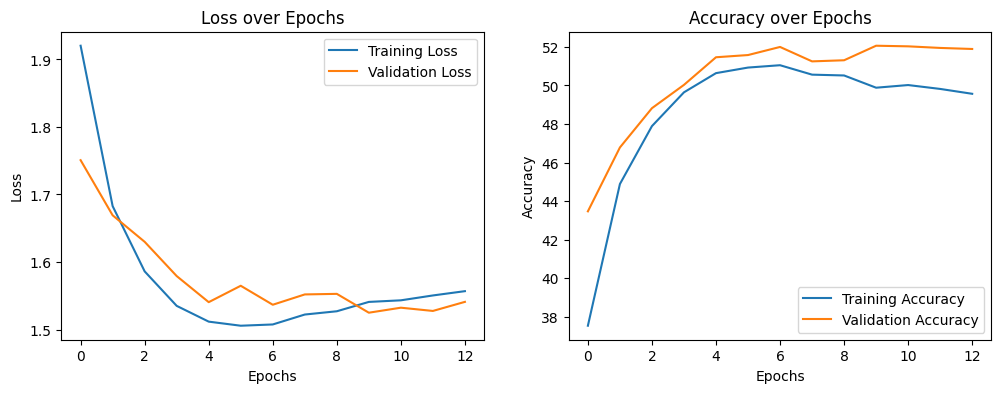

In [ ]:
# Training the model
train_acc = []
val_acc = []
train_loss = []
val_loss = []
previous_val_loss = float('inf')
val_patience = 3
val_counter = 0

for epoch in range(epochs):
    model_3.train()
    train_true = []
    train_pred = []
    train_running_loss = 0.0

    for inputs, targets in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        train_inputs, train_targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        train_outputs = model_3(train_inputs)
        loss = loss_function(train_outputs, train_targets)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, pred = torch.max(train_outputs, 1)
        train_true.extend(train_targets.cpu().numpy())
        train_pred.extend(pred.cpu().numpy())

    model_3.eval()
    val_true = []
    val_pred = []
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            val_inputs, val_targets = inputs.to(device), targets.to(device)

            val_outputs = model_3(val_inputs)
            loss = loss_function(val_outputs, val_targets)
            val_running_loss += loss.item()
            _, pred = torch.max(val_outputs, 1)
            val_true.extend(val_targets.cpu().numpy())
            val_pred.extend(pred.cpu().numpy())

    train_loss.append(train_running_loss / len(train_dataloader))
    train_acc.append((np.array(train_true) == np.array(train_pred)).sum() / len(train_true) * 100)
    val_loss.append(val_running_loss / len(val_dataloader))
    val_acc.append((np.array(val_true) == np.array(val_pred)).sum() / len(val_true) * 100)

    print(f"Epoch #{epoch+1} | Training Loss: {train_loss[-1]:.3f} | Training Accuracy: {train_acc[-1]:.2f}%")
    print(f"Epoch #{epoch+1} | Validation Loss: {val_loss[-1]:.3f} | Validation Accuracy: {val_acc[-1]:.2f}%\n")

    # Early stopping
    if val_loss[-1] > previous_val_loss:
        val_counter += 1
        if val_counter >= val_patience:
            print('Early stopping condition met. Validation loss is increasing.')
            break
    else:
        previous_val_loss = val_loss[-1]
        val_counter = 0
        best_weights_3 = model_3.state_dict()

# Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

## **STEP 6:** Model Evaluations

Experiment 0 - Test Loss: 0.9994 | Test Accuracy: 70.82%
Experiment 1 - Test Loss: 1.0947 | Test Accuracy: 69.37%
Experiment 2 - Test Loss: 1.5249 | Test Accuracy: 51.89%
Best model saved.
Model saved to jamatzal_chellapp_assignment2_part1_best_lstm_model.pkl
Best Model (model_1) - Test Loss: 0.9994 | Test Accuracy: 70.82%


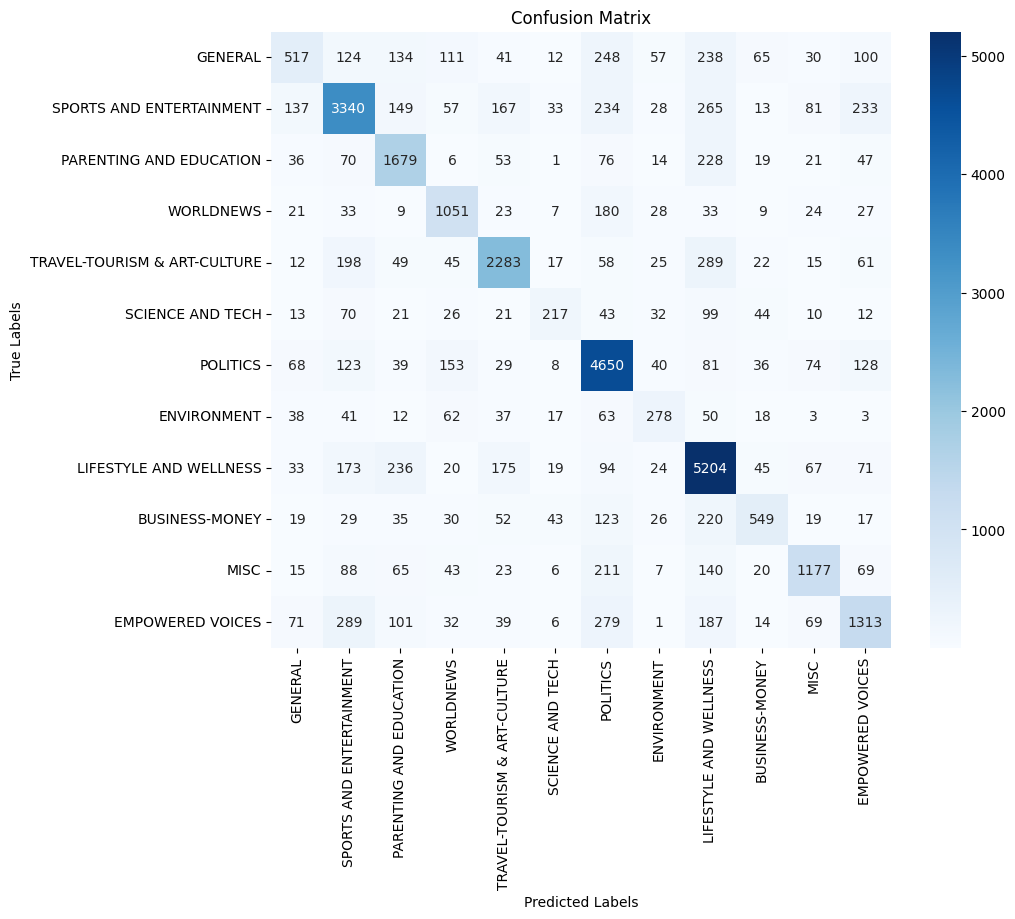

In [ ]:
def evaluate_model(model, dataloader, loss_function):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass through the model
            outputs = model(inputs)

            # calculating the batch loss
            loss = loss_function(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            # calculating the number of correct predictions for the batch
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == targets.data)

            # appending the test predictions and the true targets
            test_predictions.extend(preds.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc, test_predictions, test_targets

# Example training loop and model evaluation
models = [model_1, model_2, model_3]
model_names = ["model_1", "model_2", "model_3"]
best_model = None
best_accuracy = 0.0

for i, model in enumerate(models):

    # Evaluate model on validation set
    test_loss, test_acc, _, _ = evaluate_model(model, test_dataloader, nn.CrossEntropyLoss())
    print(f"Experiment {i} - Test Loss: {test_loss:.4f} | Test Accuracy: {(test_acc)*100:.2f}%")

    # Determine if this model is the best based on validation accuracy
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model = model
        best_model_name = model_names[i]

# Save the best model's weights
torch.save(best_model.state_dict(), 'jamatzal_chellapp_assignment2_part1_best_lstm_model.pth')
print(f"Best model saved.")

# Save the best model using pickle
best_model_pkl_path = "jamatzal_chellapp_assignment2_part1_best_lstm_model.pkl"
with open(best_model_pkl_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved to {best_model_pkl_path}")

# Evaluate the best model using the test set
test_loss, test_acc, test_predictions, test_targets = evaluate_model(best_model, test_dataloader, nn.CrossEntropyLoss())
print(f"Best Model ({best_model_name}) - Test Loss: {test_loss:.4f} | Test Accuracy: {(test_acc)*100:.2f}%")

# Generate confusion matrix for test set
cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


This LSTM architecture consists of 6 layers, each with 256 hidden units and 20% dropout between layers. The final output is passed through a linear layer to produce predictions. It is trained using the Adam optimizer with a learning rate of 0.001 and employs early stopping based on validation loss. The model is evaluated using CrossEntropyLoss and monitored for both training and validation accuracy and loss across 20 epochs.

During training, the LSTM model shows consistent improvement in both training and validation metrics over the 10 epochs, with training loss decreasing from 2.093 to 0.809 and training accuracy increasing from 30.25% to 75.53%. Similarly, validation loss decreases from 1.938 to 1.169, and validation accuracy increases from 38.00% to 67.38%. The early stopping mechanism halts training as validation loss starts to increase, indicating the model's ability to generalize might deteriorate beyond this point.

## **STEP 7:** GRU Model

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, num_layers, dropout, bidirectional=False):
        super().__init__()

        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(embedding_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers,
                          bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        output, hidden = self.gru(x)

        # concatenates the hidden states from both directions if bidirectional
        if self.bidirectional:
          hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
          hidden = self.dropout(hidden[-1,:,:])

        output = self.fc(hidden)
        return output


## **STEP 8:** Experimenting with Different Settings

In [ ]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, num_epochs, optimizer, loss_function):
    train_loss, val_loss = [], [] # initializing loss lists
    train_acc, val_acc = [], []  # initializing accuracy lists
    previous_val_loss = float('inf')
    val_patience = 3
    val_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_running_loss, train_running_correct = 0.0, 0

        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad() # zeroing the parameters

            outputs = model(inputs) # forward pass through the model

            loss = loss_function(outputs, targets) # calculating the loss
            train_running_loss += loss.item() * inputs.size(0)
            # multiplying the loss by the number of samples in the batch, thereby weighting its loss value
            # this is because the last batch may have fewer samples

            loss.backward() # backpropogation
            optimizer.step()

           # determining accurate predictions
            _, preds = torch.max(outputs, 1)
            train_running_correct += torch.sum(preds == targets.data)

        # calculating/appending epoch loss and accuracy
        epoch_loss = train_running_loss / len(train_dataloader.dataset) # dividing by the total number of samples
        epoch_acc = train_running_correct.double() / len(train_dataloader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())

        model.eval()
        val_running_loss, val_running_correct = 0.0, 0

        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs) # forward pass
                loss = loss_function(outputs, targets) # loss calculation
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_correct += torch.sum(preds == targets.data) # determining accurate predictions

        # calculating/appending epoch loss and accuracy
        val_epoch_loss = val_running_loss / len(val_dataloader.dataset)
        val_epoch_acc = val_running_correct.double() / len(val_dataloader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1:2d} | Train Loss: {epoch_loss:.4f}, Train Acc: {(epoch_acc)*100:.2f} | Val Loss: {val_epoch_loss:.4f}, Val Acc: {(val_epoch_acc)*100:.2f}')

        # Early stopping
        if val_loss[-1] > previous_val_loss:
            val_counter += 1
            if val_counter >= val_patience:
                print('Early stopping condition met. Validation loss is increasing.')
                break
        else:
            previous_val_loss = val_loss[-1]
            val_counter = 0

    return train_loss, train_acc, val_loss, val_acc

# Function to plot the training and validation metrics
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, experiment_num):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title(f'Experiment {experiment_num} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title(f'Experiment {experiment_num} - Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

#### EXPERIMENT #1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch  1 | Train Loss: 2.0836, Train Acc: 30.53 | Val Loss: 1.9106, Val Acc: 38.68
Epoch  2 | Train Loss: 1.7683, Train Acc: 42.50 | Val Loss: 1.6241, Val Acc: 48.26
Epoch  3 | Train Loss: 1.5190, Train Acc: 51.72 | Val Loss: 1.3715, Val Acc: 58.37
Epoch  4 | Train Loss: 1.3443, Train Acc: 58.32 | Val Loss: 1.2653, Val Acc: 62.02
Epoch  5 | Train Loss: 1.2329, Train Acc: 61.95 | Val Loss: 1.1781, Val Acc: 64.31
Epoch  6 | Train Loss: 1.1557, Train Acc: 64.30 | Val Loss: 1.1356, Val Acc: 65.61
Epoch  7 | Train Loss: 1.0926, Train Acc: 66.37 | Val Loss: 1.1016, Val Acc: 66.80
Epoch  8 | Train Loss: 1.0402, Train Acc: 67.94 | Val Loss: 1.0750, Val Acc: 67.65
Epoch  9 | Train Loss: 0.9935, Train Acc: 69.29 | Val Loss: 1.0528, Val Acc: 68.28
Epoch 10 | Train Loss: 0.9520, Train Acc: 70.51 | Val Loss: 1.0473, Val Acc: 68.81
Epoch 11 | Train Loss: 0.9156, Train Acc: 71.53 | Val Loss: 1.0252, Val Acc: 69.52
Epoch 12 | Train Loss: 0.8817, Train Acc: 72.54 | Val Loss: 1.0216, Val Acc: 69.59
Epoc

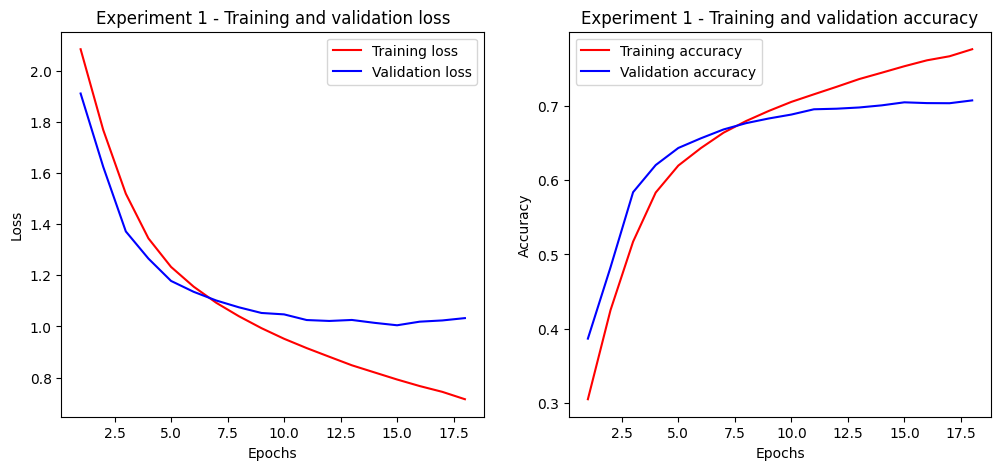

In [ ]:
# Experiment #1: Base GRU model
embedding_size = len(vocab)
hidden_size = 128
num_layers = 1
dropout = 0.4
learning_rate = 0.001
num_epochs = 50

model_a1 = GRUModel(embedding_size, hidden_size, num_categories, num_layers, dropout).to(device)
optimizer1 = torch.optim.Adam(model_a1.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(model_a1, train_dataloader, val_dataloader, num_epochs, optimizer1, loss_function)
plot_metrics(train_losses1, train_accuracies1, val_losses1, val_accuracies1, experiment_num = 1)

#### EXPERIMENT #2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch  1 | Train Loss: 2.0279, Train Acc: 33.09 | Val Loss: 1.7757, Val Acc: 43.20
Epoch  2 | Train Loss: 1.6031, Train Acc: 48.79 | Val Loss: 1.3659, Val Acc: 58.47
Epoch  3 | Train Loss: 1.3348, Train Acc: 58.74 | Val Loss: 1.1973, Val Acc: 63.65
Epoch  4 | Train Loss: 1.2070, Train Acc: 62.81 | Val Loss: 1.1145, Val Acc: 65.81
Epoch  5 | Train Loss: 1.1182, Train Acc: 65.49 | Val Loss: 1.0723, Val Acc: 67.26
Epoch  6 | Train Loss: 1.0519, Train Acc: 67.55 | Val Loss: 1.0327, Val Acc: 68.47
Epoch  7 | Train Loss: 0.9950, Train Acc: 69.23 | Val Loss: 1.0254, Val Acc: 69.28
Epoch  8 | Train Loss: 0.9477, Train Acc: 70.53 | Val Loss: 0.9954, Val Acc: 69.76
Epoch  9 | Train Loss: 0.9116, Train Acc: 71.63 | Val Loss: 0.9815, Val Acc: 70.22
Epoch 10 | Train Loss: 0.8770, Train Acc: 72.59 | Val Loss: 0.9728, Val Acc: 70.59
Epoch 11 | Train Loss: 0.8443, Train Acc: 73.64 | Val Loss: 0.9713, Val Acc: 70.83
Epoch 12 | Train Loss: 0.8179, Train Acc: 74.38 | Val Loss: 0.9677, Val Acc: 71.04
Epoc

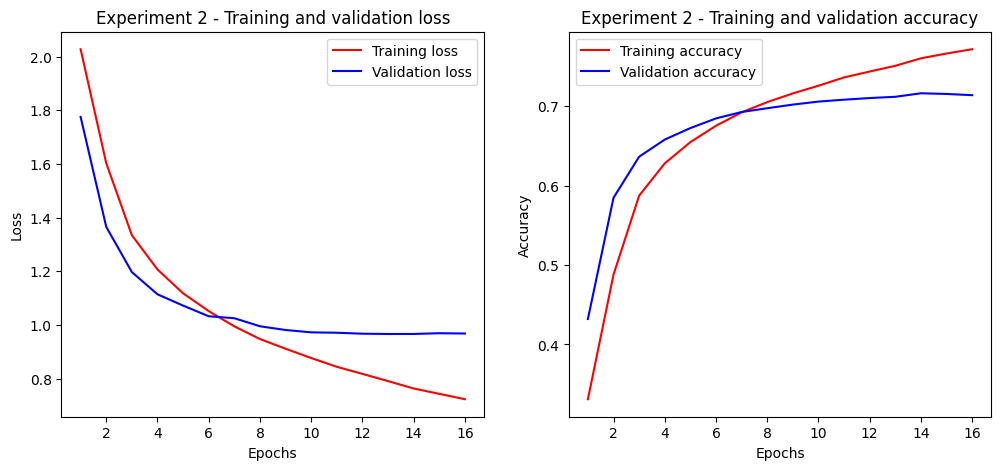

In [ ]:
# Experiment #2: GRU model with increased hidden size, and bidirectional
embedding_size = len(vocab)
hidden_size = 256 # 128 -> 256
num_layers = 1
dropout = 0.5 # 0.4 -> 0.5
bidirectional = True # True
learning_rate = 0.001
num_epochs = 50

model_a2 = GRUModel(embedding_size, hidden_size, num_categories, num_layers, dropout).to(device)
optimizer2 = torch.optim.Adam(model_a2.parameters(), lr=learning_rate)

train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(
    model_a2, train_dataloader, val_dataloader, num_epochs, optimizer2, loss_function)
plot_metrics(train_losses2, train_accuracies2, val_losses2, val_accuracies2, experiment_num=2)

#### EXPERIMENT #3

Epoch  1 | Train Loss: 1.9259, Train Acc: 36.61 | Val Loss: 1.5889, Val Acc: 49.78
Epoch  2 | Train Loss: 1.4058, Train Acc: 56.03 | Val Loss: 1.2178, Val Acc: 62.61
Epoch  3 | Train Loss: 1.1796, Train Acc: 63.45 | Val Loss: 1.1307, Val Acc: 65.93
Epoch  4 | Train Loss: 1.0530, Train Acc: 67.34 | Val Loss: 1.0604, Val Acc: 68.30
Epoch  5 | Train Loss: 0.9664, Train Acc: 70.00 | Val Loss: 1.0271, Val Acc: 68.95
Epoch  6 | Train Loss: 0.8999, Train Acc: 71.81 | Val Loss: 0.9923, Val Acc: 69.95
Epoch  7 | Train Loss: 0.8442, Train Acc: 73.42 | Val Loss: 0.9933, Val Acc: 70.19
Epoch  8 | Train Loss: 0.7997, Train Acc: 74.81 | Val Loss: 0.9861, Val Acc: 70.68
Epoch  9 | Train Loss: 0.7586, Train Acc: 75.99 | Val Loss: 0.9714, Val Acc: 71.11
Epoch 10 | Train Loss: 0.7194, Train Acc: 77.06 | Val Loss: 1.0032, Val Acc: 71.03
Epoch 11 | Train Loss: 0.6837, Train Acc: 78.16 | Val Loss: 0.9967, Val Acc: 71.06
Epoch 12 | Train Loss: 0.6567, Train Acc: 78.95 | Val Loss: 1.0100, Val Acc: 71.20
Earl

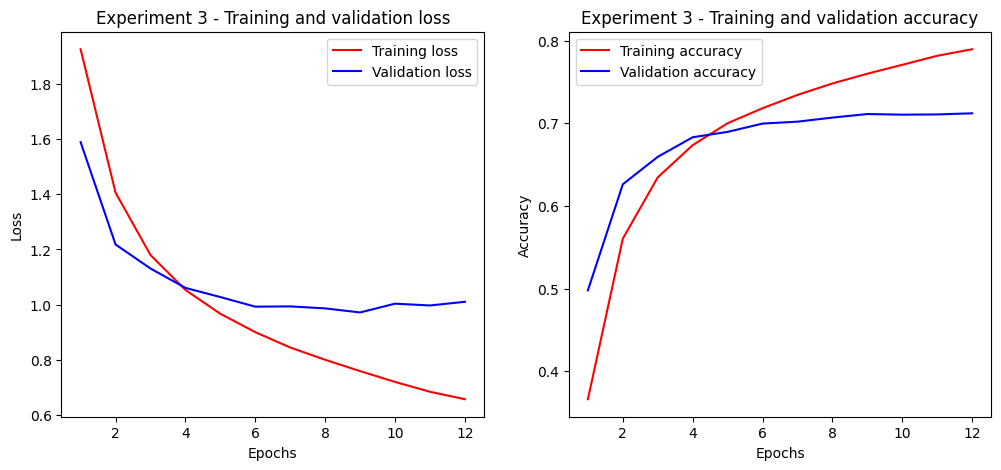

In [ ]:
# Experiment #3: GRU model with more layers, more hidden units, and bidirectional
embedding_size = len(vocab)
hidden_size = 256 # 128 -> 256
num_layers = 3 # 1 -> 3
dropout = 0.4
bidirectional = True # True
learning_rate = 0.001
num_epochs = 50

model_a3 = GRUModel(embedding_size, hidden_size, num_categories, num_layers, dropout).to(device)
optimizer3 = torch.optim.Adam(model_a3.parameters(), lr=learning_rate)

train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(
    model_a3, train_dataloader, val_dataloader, num_epochs, optimizer3, loss_function)
plot_metrics(train_losses3, train_accuracies3, val_losses3, val_accuracies3, experiment_num=3)

## **STEP 9:** Evaluating the Improved Models

Experiment 1 - Validation Loss: 1.0328, Validation Accuracy: 0.7071
Experiment 2 - Validation Loss: 0.9684, Validation Accuracy: 0.7140
Experiment 3 - Validation Loss: 1.0100, Validation Accuracy: 0.7120
Best model saved.
Model saved to jamatzal_chellapp_assignment2_part1_best_advanced_lstm_model.pkl
Best Model (model_1) - Test Loss: 0.9532, Test Accuracy: 0.7170


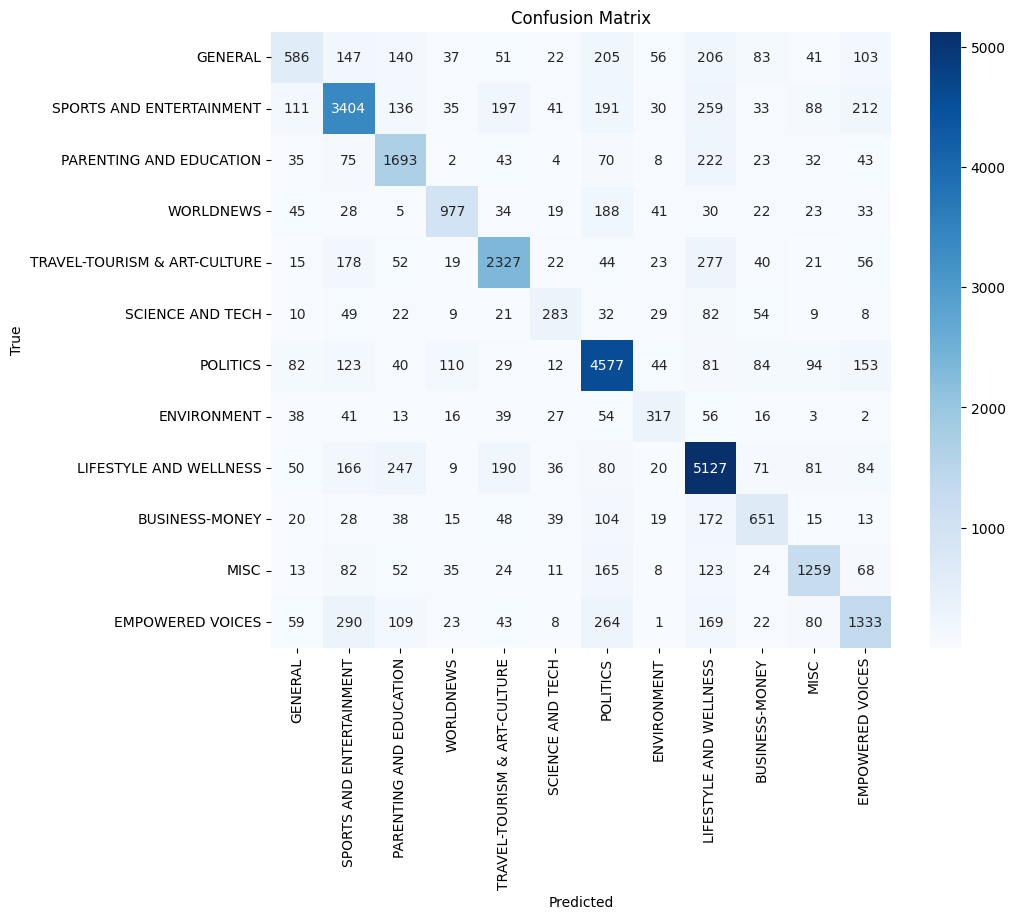

In [ ]:
def evaluate_model(model, dataloader, loss_function):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == targets.data)

            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc, all_predictions, all_targets

# Evaluate model 1
val_loss1, val_acc1, _, _ = evaluate_model(model_a1, val_dataloader, loss_function)
print(f"Experiment 1 - Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_acc1:.4f}")

# Evaluate model 2
val_loss2, val_acc2, _, _ = evaluate_model(model_a2, val_dataloader, loss_function)
print(f"Experiment 2 - Validation Loss: {val_loss2:.4f}, Validation Accuracy: {val_acc2:.4f}")

# Evaluate model 3
val_loss3, val_acc3, _, _ = evaluate_model(model_a3, val_dataloader, loss_function)
print(f"Experiment 3 - Validation Loss: {val_loss3:.4f}, Validation Accuracy: {val_acc3:.4f}")

# Determine the best model based on validation accuracy
best_model = None
best_accuracy = 0.0

if val_acc1 > best_accuracy:
    best_accuracy = val_acc1
    best_model = model_a1

if val_acc2 > best_accuracy:
    best_accuracy = val_acc2
    best_model = model_a2

if val_acc3 > best_accuracy:
    best_accuracy = val_acc3
    best_model = model_a3

# Save the weights of the best model
torch.save(best_model.state_dict(), 'jamatzal_chellapp_assignment2_part1_best_advanced_lstm_model.pth')
print("Best model saved.")

# Load the best model's weights
best_model.load_state_dict(torch.load('jamatzal_chellapp_assignment2_part1_best_advanced_lstm_model.pth'))
best_model.eval()


b_model_pkl_path = "jamatzal_chellapp_assignment2_part1_best_advanced_lstm_model.pkl"
with open(b_model_pkl_path, 'wb') as f:
    pickle.dump(model_3, f)
print(f"Model saved to {b_model_pkl_path}")

# Evaluate the best model using the test set
test_loss, test_acc, test_predictions, test_targets = evaluate_model(best_model, test_dataloader, loss_function)
print(f"Best Model ({best_model_name}) - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


This GRU architecture employs an embedding layer followed by a single-layer GRU with 256 hidden units, dropout of 0.5, and a linear layer for classification. It is trained using the Adam optimizer with a learning rate of 0.001 over 10 epochs, evaluating both training and validation loss and accuracy. The model demonstrates its capability to learn sequential data representations similar to LSTM but with potentially faster training times due to its simpler gating mechanism.


The training and validation graphs illustrate a clear pattern of decreasing loss and increasing accuracy across the 10 epochs for both training and validation sets. This indicates that the GRU model effectively learns from the data over time, improving its predictive performance. The final validation accuracy of approximately 71.48% suggests that the model achieves reasonable performance on unseen data, highlighting its ability to generalize well. The consistent improvement in both metrics reaffirms the effectiveness of the GRU architecture in handling sequential data tasks such as text classification.

Increasing the hidden size in the LSTM model typically results in improved performance metrics such as lower validation loss and higher validation accuracy compared to a base LSTM with smaller hidden units. This enhancement allows the model to capture more intricate patterns in sequential data, demonstrating the impact of architectural adjustments on model effectiveness in tasks like text classification.

Recurrent neural models like LSTM and GRU are strong for sentiment analysis due to their ability to capture sequential dependencies and handle variable-length inputs. However, they can be computationally intensive and may struggle with long-range dependencies and ambiguous contexts, impacting their performance in complex language understanding tasks.


In [ ]:
from google.colab import files

files.download('/content/jamatzal_chellapp_assignment2_part1_best_advanced_lstm_model.pkl')
files.download('/content/jamatzal_chellapp_assignment2_part1_best_advanced_lstm_model.pth')

files.download('/content/jamatzal_chellapp_assignment2_part1_best_lstm_model.pkl')
files.download('/content/jamatzal_chellapp_assignment2_part1_best_lstm_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **References**

- https://www.kaggle.com/datasets/rmisra/news-category-dataset
- https://www.youtube.com/watch?v=CrS-LFXEiyk
- https://www.youtube.com/watch?v=1EKQwhCW_y8
- https://www.youtube.com/watch?v=mxj5eUY8FlY
- https://www.kaggle.com/code/alfarias/huffpost-news-classification-with-distilbert
- https://www.kaggle.com/code/derinrobert/newsclassification-using-lstm-val-acc-72